In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd

import matplotlib
font = {'size': 16}

matplotlib.rc('font', **font)

In [2]:
N_SEGMENTS = 3

IMAGE_ROOT = "signal_img_example"
SIGNAL_ROOT = "signal_example"

In [3]:
def gen_interpolation(x_1: float, x_2: float):
    num_interpolation = max(int((np.ceil(np.log2(np.abs(x_1-x_2))))**2), 1)
    delta = 1.0*np.abs(x_1-x_2)/num_interpolation
    interpolations = []
    for idx in range(1, num_interpolation):
        if x_1 < x_2:
            interpolations.append(x_1+idx*np.random.normal(delta, 0.1*delta))
        else:
            interpolations.append(x_1-idx*np.random.normal(delta, 0.1*delta))
    return interpolations

In [4]:
def gen_signal():
    # segment_length = [int(np.random.uniform(10, 30)) for _ in range(N_SEGMENTS)]
    segment_length = [30]*3
    # segment_mean = [int(np.random.uniform(0, 20)) for _ in range(N_SEGMENTS)]
    segment_mean = [5,20,10]
    # random.shuffle(segment_mean)
    segment_list = [np.random.normal(segment_mean[idx], 1, segment_length[idx]) for idx in range(N_SEGMENTS)]

    segment_boundary = [0]
    signal = []
    cps = []
    for idx in range(N_SEGMENTS-1):
        segment_boundary.append(len(signal)+len(segment_list[idx]))
        signal.extend(segment_list[idx])
        prev_tail = segment_list[idx][-1]
        post_head = segment_list[idx+1][0]
        interpolations = gen_interpolation(prev_tail, post_head)
        if segment_mean[idx] != segment_mean[idx]+1:
            cps.append(len(signal)+len(interpolations)//2)
            segment_boundary.append(len(signal)+len(interpolations))
            signal.extend(interpolations)
    signal.extend(segment_list[-1])
    segment_boundary.append(len(signal)-1)

    cp_one_hot = [0]*len(signal)
    for cp in cps:
        cp_one_hot[cp] = 1

    return signal, segment_boundary, cp_one_hot

In [5]:
def plot_signal(signal, segment_boundary, cp_one_hot):
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 3)
    ax.plot(range(len(signal)), signal, color="#3F51B5", label="x")
    ax.scatter(range(len(signal)), signal, color="#3F51B5")
    bd_line = None
    for boundary in segment_boundary:
        bd_line = ax.axvline(x=boundary, color="#00BCD4", linestyle="--")
    bd_line.set_label("seg boundary")
    cp_line = None
    for cp in np.where(np.array(cp_one_hot) == 1)[0]:
        cp_line = ax.axvline(x=cp, color="#FF9800", linestyle="--")
    cp_line.set_label("gt cp")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_title("synthetic data example")
    ax.legend(loc=(0.7,0.55))
    ax.grid(True, linestyle="--")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig, ax

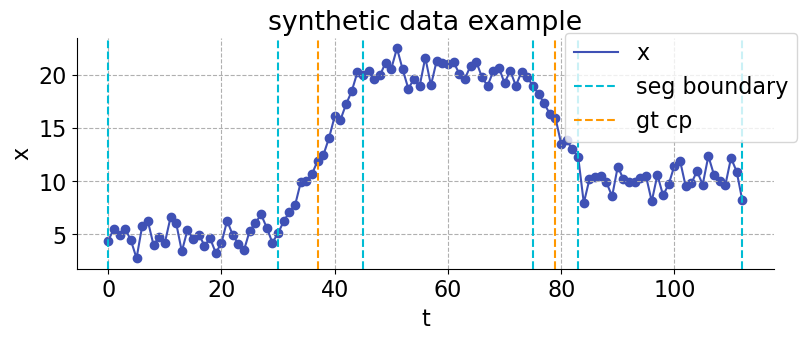

In [6]:
signal, segment_boundary, cp_one_hot = gen_signal()
fig, ax = plot_signal(signal, segment_boundary, cp_one_hot)

if not os.path.exists(IMAGE_ROOT):
    os.makedirs(IMAGE_ROOT)
if not os.path.exists(SIGNAL_ROOT):
    os.makedirs(SIGNAL_ROOT)
fig.savefig(os.path.join(IMAGE_ROOT, "signal_example.pdf"))
df = pd.DataFrame({"signal": signal, "is_change_point": cp_one_hot})
df.to_csv(os.path.join(SIGNAL_ROOT, "signal_example.csv"), index=False)
